In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model

In [2]:
(x_train,y_train),(x_test,y_test) = datasets.mnist.load_data()
x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)
x_val = x_train[-2000:,:,:,:]
y_val = y_train[-2000:]
x_train = x_train[:-2000,:,:,:]
y_train = y_train[:-2000]

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
def inception(x,
              filters_1x1,
              filters_3x3_reduce,
              filters_3x3,
              filters_5x5_reduce,
              filters_5x5,
              filters_pool):
  path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same',    activation='relu')(x)
  path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
  path2 = layers.Conv2D(filters_3x3, (1, 1), padding='same', activation='relu')(path2)
  path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
  path3 = layers.Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(path3)
  path4 = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  path4 = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(path4)
  return tf.concat([path1, path2, path3, path4], axis=3)

In [4]:
inp = layers.Input(shape=(32, 32, 3))
input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:])(inp)
x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_tensor)
x = layers.MaxPooling2D(3, strides=2)(x)
x = layers.Conv2D(64, 1, strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, strides=1, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool=32)
x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool=64)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool=64)
aux1 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux1 =layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(10, activation='softmax')(aux1)
x = inception(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
x = inception(x, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool=64)
aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 =layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2)
aux2 = layers.Dense(10, activation='softmax')(aux2)
x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
x = inception(x, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool=128)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
out = layers.Dense(10, activation='softmax')(x)

In [5]:
model = Model(inputs = inp, outputs = [out, aux1, aux2])

In [6]:
model.compile(optimizer='adam',
              loss=[losses.sparse_categorical_crossentropy,
                    losses.sparse_categorical_crossentropy,
                    losses.sparse_categorical_crossentropy],
              loss_weights=[1, 0.3, 0.3],
              metrics=['accuracy'])
history = model.fit(x_train, [y_train, y_train, y_train], validation_data=(x_val, [y_val, y_val, y_val]), batch_size=64, epochs=10)

Epoch 1/10
907/907 [==============================] - 174s 158ms/step - loss: 1.2952 - dense_4_loss: 0.9410 - dense_1_loss: 0.5594 - dense_3_loss: 0.6213 - dense_4_accuracy: 0.6631 - dense_1_accuracy: 0.8112 - dense_3_accuracy: 0.7877 - val_loss: 0.1903 - val_dense_4_loss: 0.1427 - val_dense_1_loss: 0.0785 - val_dense_3_loss: 0.0801 - val_dense_4_accuracy: 0.9585 - val_dense_1_accuracy: 0.9765 - val_dense_3_accuracy: 0.9790
Epoch 2/10
907/907 [==============================] - 138s 152ms/step - loss: 0.2483 - dense_4_loss: 0.1734 - dense_1_loss: 0.1206 - dense_3_loss: 0.1291 - dense_4_accuracy: 0.9485 - dense_1_accuracy: 0.9625 - dense_3_accuracy: 0.9612 - val_loss: 0.0918 - val_dense_4_loss: 0.0635 - val_dense_1_loss: 0.0446 - val_dense_3_loss: 0.0496 - val_dense_4_accuracy: 0.9810 - val_dense_1_accuracy: 0.9895 - val_dense_3_accuracy: 0.9840
Epoch 3/10
907/907 [==============================] - 139s 153ms/step - loss: 0.1580 - dense_4_loss: 0.1061 - dense_1_loss: 0.0844 - dense_3_los

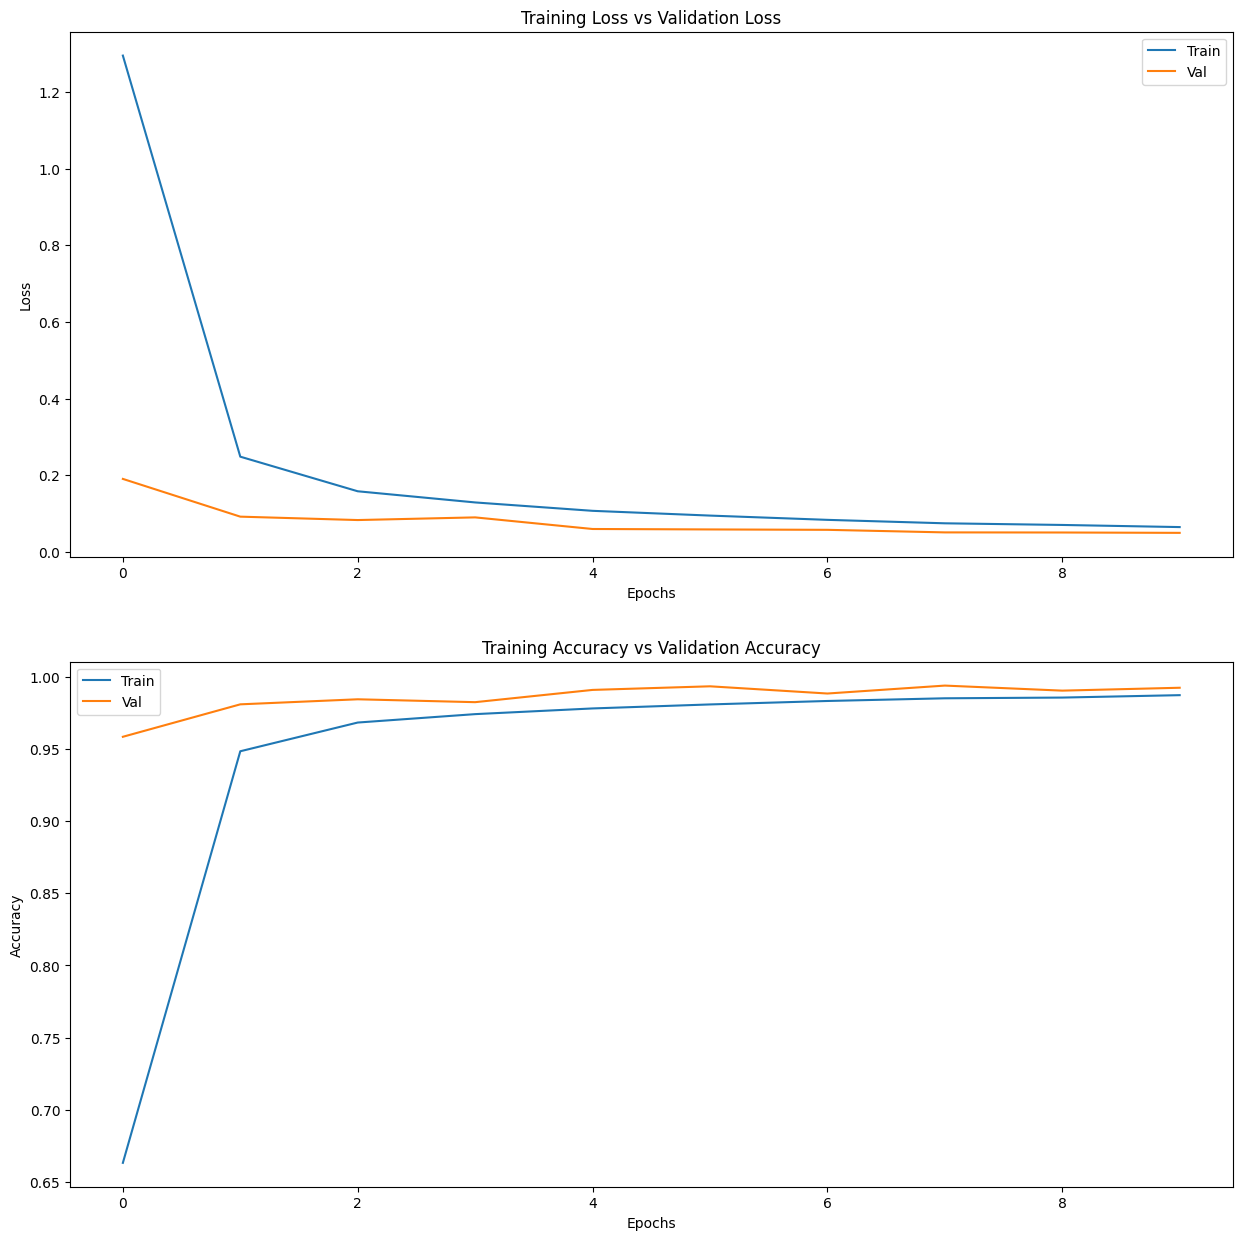

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['dense_4_accuracy'])
axs[1].plot(history.history['val_dense_4_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [8]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 11s 26ms/step - loss: 0.0723 - dense_4_loss: 0.0490 - dense_1_loss: 0.0360 - dense_3_loss: 0.0415 - dense_4_accuracy: 0.9842 - dense_1_accuracy: 0.9894 - dense_3_accuracy: 0.9864


[0.07225649058818817,
 0.04901298135519028,
 0.03596413880586624,
 0.041514284908771515,
 0.9842000007629395,
 0.9894000291824341,
 0.9864000082015991]